# Differentially private random feature models: Synthetic data

We test on two synthetic datasets and compare the following methods:

1. Our method
2. Modified Chaudi --  different random noises are added. Does not perform well
3. DPSGD (does not converge to min-norm solution, requires r in theory.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time

from scipy import io
from matplotlib import cm

from DP_RF import *

#### Test function 1

- test error vs number of features (N)

- privacy budget is 1

In [2]:
m = 1000       # number of training/test samples
d = 5          # ambient dimension
gamma = 20      # scale of kernel
epsilon = 1    # private budget
delta = 1e-5   # privacy parameter
N_range = range(1500,5500,500)

X, Y = generate_data(2*m, d, fun1)
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.5)

# error and time
K = 10   # repeat K times
err_np = np.zeros( (len(N_range), K) )
err_ours = np.zeros( (len(N_range), K) )
err_chaudi = np.zeros( (len(N_range), K) )
err_obj = np.zeros( (len(N_range), K) )
err_SGD_np = np.zeros( (len(N_range), K) )
err_SGD = np.zeros( (len(N_range), K) )

time_our = np.zeros( (len(N_range), K) )
time_obj = np.zeros( (len(N_range), K) )
time_SGD = np.zeros( (len(N_range), K) )

In [3]:
for i in range(len(N_range)):
    
    N = N_range[i]
    Delta_c = 4/np.sqrt(N)    # l2-sensitivity
    
    for j in range(K):
    
        # random feature matrix
        A_train, A_test = RF_Gaussian(gamma, N, x_train, x_test)
    
        # our method
        start = time.time()
        #c = np.linalg.pinv(A_train) @ y_train   # non-private
        c = randomized_kaczmarz(A_train, y_train, np.zeros((N,)), 1000)
        c_ours = private(c, Delta_c, epsilon, delta, "Gaussian")  # private ours
        end = time.time()
        time_our[i,j] = end - start
        err_np[i,j] = np.linalg.norm(y_test - A_test @ c)**2 / m
        err_ours[i,j] = np.linalg.norm(y_test - A_test @ c_ours)**2 / m
    
        # chaudi
        c_chaudi = private(c, Delta_c, epsilon, delta, "Gamma")
        err_chaudi[i,j] = np.linalg.norm(y_test - A_test @ c_chaudi)**2 / m
    
        ## objective perturbation
        reg = 1e-5       # regularization parameter, should be small
        start = time.time()
        c_obj = objective_perturb(epsilon, 2, A_train, y_train, lamb=reg)
        end = time.time()
        time_obj[i,j] = end - start
        err_obj[i,j] = np.linalg.norm(y_test - A_test @ c_obj)**2 / m
    
        ## SGD
        eta = 1/m        # learning rate
        T = 1000        # number of iterations
        start = time.time()
        c_SGD_np, c_SGD = DPRF_SGD(epsilon, delta, A_train, y_train, T, eta)
        end = time.time()
        time_SGD[i,j] = end - start
        err_SGD_np[i,j] = np.linalg.norm(y_test - A_test @ c_SGD_np)**2 / m
        err_SGD[i,j] = np.linalg.norm(y_test - A_test @ c_SGD)**2 / m

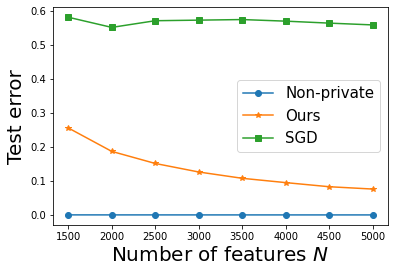

In [4]:
plt.plot(N_range, np.mean(err_np, axis=1), '-o', label='Non-private')
plt.plot(N_range, np.mean(err_ours,axis=1), '-*', label='Ours')
#plt.plot(N_range, np.mean(err_chaudi,axis=1), '-s', label='Chaudhuri')
#plt.plot(N_range, np.mean(err_obj,axis=1), '-s', label='Objective perturbation')
plt.plot(N_range, np.mean(err_SGD,axis=1), '-s', label='SGD')
plt.legend(fontsize=15)
plt.ylabel('Test error', size=20)
plt.xlabel(r'Number of features $N$', size=20)
plt.savefig('F1_eps=1.pdf', bbox_inches = 'tight')

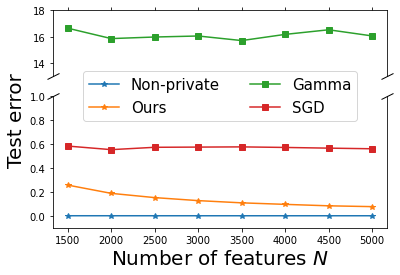

In [5]:
# Plotting function
def plot(ax):
    ax.plot(N_range, np.mean(err_np, axis=1), '-*', label='Non-private')
    ax.plot(N_range, np.mean(err_ours,axis=1), '-*', label='Ours')
    ax.plot(N_range, np.mean(err_chaudi,axis=1), '-*', label='Gamma')
    ax.plot(N_range, np.mean(err_SGD,axis=1), '-*', label='SGD')
    #plt.ylabel('Mean test error', size=20)
    plt.xlabel(r'Number of features $N$', size=20)

# Draw the graph on two subplots
# Bottom graph is twice the size of the top one
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 2]})
plot(ax1)
plot(ax2)

# Changes graph axes
ax1.set_ylim(13, 18) # Top graph
ax2.set_ylim(-0.1, 1) # Bottom graph

# Hides the spines between the axes
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Adds slanted lines to axes
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle='none',
    color='k',
    mec='k',
    mew=1,
    clip_on=False
)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
plt.legend(loc='center',bbox_to_anchor=(0.5, 1),fontsize=15,ncol=2)
fig.text(0.02, 0.5, 'Test error', va='center', rotation='vertical', size=20)
plt.savefig('F1_broken_eps=1.pdf', bbox_inches = 'tight')

#### Test function 1

- test error vs number of features (N)

- privacy budget is 0.5

In [10]:
m = 1000       # number of training/test samples
d = 5          # ambient dimension
gamma = 20      # scale of kernel
epsilon = 0.5    # private budget
delta = 1e-5   # privacy parameter
N_range = range(1500,5500,500)

X, Y = generate_data(2*m, d, fun1)
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.5)

# error and time
K = 10   # repeat K times
err_np = np.zeros( (len(N_range), K) )
err_ours = np.zeros( (len(N_range), K) )
err_chaudi = np.zeros( (len(N_range), K) )
err_obj = np.zeros( (len(N_range), K) )
err_SGD_np = np.zeros( (len(N_range), K) )
err_SGD = np.zeros( (len(N_range), K) )

time_our = np.zeros( (len(N_range), K) )
time_obj = np.zeros( (len(N_range), K) )
time_SGD = np.zeros( (len(N_range), K) )

In [11]:
for i in range(len(N_range)):
    
    N = N_range[i]
    Delta_c = 4/np.sqrt(N)    # l2-sensitivity
    
    for j in range(K):
    
        # random feature matrix
        A_train, A_test = RF_Gaussian(gamma, N, x_train, x_test)
    
        # our method
        start = time.time()
        #c = np.linalg.pinv(A_train) @ y_train   # non-private
        c = randomized_kaczmarz(A_train, y_train, np.zeros((N,)), 1000)
        c_ours = private(c, Delta_c, epsilon, delta, "Gaussian")  # private ours
        end = time.time()
        time_our[i,j] = end - start
        err_np[i,j] = np.linalg.norm(y_test - A_test @ c)**2 / m
        err_ours[i,j] = np.linalg.norm(y_test - A_test @ c_ours)**2 / m
    
        # chaudi
        c_chaudi = private(c, Delta_c, epsilon, delta, "Gamma")
        err_chaudi[i,j] = np.linalg.norm(y_test - A_test @ c_chaudi)**2 / m
    
        ## objective perturbation
        reg = 1e-5       # regularization parameter, should be small
        start = time.time()
        c_obj = objective_perturb(epsilon, 2, A_train, y_train, lamb=reg)
        end = time.time()
        time_obj[i,j] = end - start
        err_obj[i,j] = np.linalg.norm(y_test - A_test @ c_obj)**2 / m
    
        ## SGD
        eta = 1/m        # learning rate
        T = 1000        # number of iterations
        start = time.time()
        c_SGD_np, c_SGD = DPRF_SGD(epsilon, delta, A_train, y_train, T, eta)
        end = time.time()
        time_SGD[i,j] = end - start
        err_SGD_np[i,j] = np.linalg.norm(y_test - A_test @ c_SGD_np)**2 / m
        err_SGD[i,j] = np.linalg.norm(y_test - A_test @ c_SGD)**2 / m

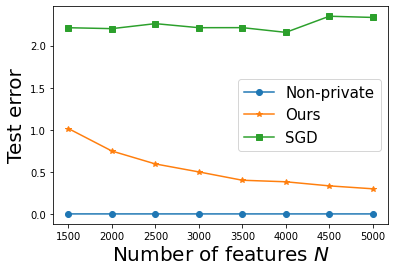

In [12]:
plt.plot(N_range, np.mean(err_np, axis=1), '-o', label='Non-private')
plt.plot(N_range, np.mean(err_ours,axis=1), '-*', label='Ours')
#plt.plot(N_range, np.mean(err_chaudi,axis=1), '-s', label='Chaudhuri')
#plt.plot(N_range, np.mean(err_obj,axis=1), '-s', label='Objective perturbation')
plt.plot(N_range, np.mean(err_SGD,axis=1), '-s', label='SGD')
plt.legend(fontsize=15)
plt.ylabel('Test error', size=20)
plt.xlabel(r'Number of features $N$', size=20)
plt.savefig('F1_eps=05.pdf', bbox_inches = 'tight')

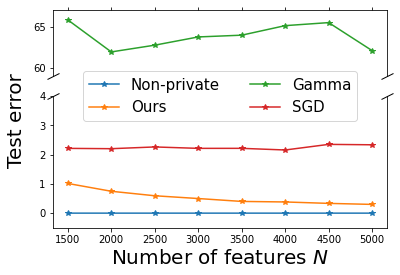

In [14]:
# Plotting function
def plot(ax):
    ax.plot(N_range, np.mean(err_np, axis=1), '-*', label='Non-private')
    ax.plot(N_range, np.mean(err_ours,axis=1), '-*', label='Ours')
    ax.plot(N_range, np.mean(err_chaudi,axis=1), '-*', label='Gamma')
    ax.plot(N_range, np.mean(err_SGD,axis=1), '-*', label='SGD')
    #plt.ylabel('Mean test error', size=20)
    plt.xlabel(r'Number of features $N$', size=20)

# Draw the graph on two subplots
# Bottom graph is twice the size of the top one
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 2]})
plot(ax1)
plot(ax2)

# Changes graph axes
ax1.set_ylim(59, 67) # Top graph
ax2.set_ylim(-0.5, 4) # Bottom graph

# Hides the spines between the axes
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Adds slanted lines to axes
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle='none',
    color='k',
    mec='k',
    mew=1,
    clip_on=False
)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
plt.legend(loc='center',bbox_to_anchor=(0.5, 1),fontsize=15,ncol=2)
fig.text(0.02, 0.5, 'Test error', va='center', rotation='vertical', size=20)
plt.savefig('F1_broken_eps=05.pdf', bbox_inches = 'tight')